<a href="https://colab.research.google.com/github/dkanzariya/Machine-learning-in-Communication-/blob/master/NOMA_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import math
import matplotlib.pyplot as plt
import torch
from torch import nn

np.random.seed(5)
N = 8
M = 8
n_iteration = 1

n_epoch = 1000
modulation_order = 2

SNR_db = np.array(list(range(2, 11, 2)))
batch_size = 1
test_size = 100

ERROR_user1 = np.zeros([len(SNR_db), n_iteration])
ERROR_user2 = np.zeros([len(SNR_db), n_iteration])

def generate_data(M, batch_size):
    input_ = [[0 for _ in range(pow(2, M))] for _ in range(M)]
    label = [[0 for _ in range(pow(2, M))] for _ in range(2 * M)]

    for i in range(1 << M):
        for j in range(M):
            if i & (1 << j):
                input_[M - j - 1][i] = 1

    for i in range(1 << M):
        for j in range(M):
            if input_[j][i] == 1:
                label[2 * j][i] = 1
                label[2 * j + 1][i] = 0
            else:
                label[2 * j][i] = 0
                label[2 * j + 1][i] = 1

    input_ = np.tile(np.array(input_), batch_size)
    label = np.tile(np.eye(1 << M), batch_size)

    return input_, label

def generate(M, N, batch_size):
    data, label = generate_data(M, batch_size)

    ran1 = np.random.permutation(batch_size * pow(2, M))  # Suffling Dataset
    ran2 = np.random.permutation(batch_size * pow(2, M))

    symbol1 = 2 * data[:, ran1] - 1
    symbol2 = 2 * data[:, ran2] - 1

    SPC = math.sqrt(0.8) * symbol1 + math.sqrt(0.2) * symbol2  # Superposition Coding

    label1 = np.transpose(label[:, ran1].astype('float32'))
    label2 = np.transpose(label[:, ran2].astype('float32'))

    return SPC, label1, label2

def generate_input(H1_real, H1_image, SPC, N, batch_size, sigma):
    N_real, N_image = generate_channel(N, batch_size * pow(2, N), 0)

    input1_real = np.matmul(H1_real, SPC) + sigma * N_real
    input1_img = np.matmul(H1_image, SPC) + sigma * N_image

    input1 = np.transpose(np.concatenate((input1_real, input1_img), axis=0))

    return input1

def generate_channel(N, M, k):
    h1 = np.random.randn(N, M) / math.sqrt(2)
    h2 = np.random.randn(N, M) / math.sqrt(2)

    if k == 0:
        return h1, h2
    else:
        return 2 * h1, 2 * h2

In [ ]:
def accuracy(output, label, M):

    correct_prediction = tf.equal(tf.math.argmax(output, 1), tf.math.argmax(label, 1))
    acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
      
    return acc

In [ ]:
import torch
from torch import nn
import torch.optim as optim

net = nn.Sequential(
    
    nn.Conv2d(1, 4, kernel_size=2, stride=1, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=1),
    nn.Conv2d(4, 8, kernel_size=2, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=1),
    nn.Flatten(),
    nn.BatchNorm1d(128),
    nn.Linear(128, 400), nn.ReLU(), nn.BatchNorm1d(400),
    nn.Linear(400, 400), nn.ReLU(), nn.BatchNorm1d(400),
    nn.Linear(400, 400), nn.ReLU(), nn.BatchNorm1d(400),
    nn.Linear(400, 400), nn.ReLU(), nn.BatchNorm1d(400),
    nn.Linear(400, 256), nn.ReLU(), nn.BatchNorm1d(256))

loss = torch.nn.CrossEntropyLoss(reduction = 'mean')

device = torch.device(f'cuda:{0}')
net1 = net.to(device = device)
net2 = net.to(device = device)

In [ ]:
H1_real, H1_image = generate_channel(N, M, 0)
H2_real, H2_image = generate_channel(N, M, 1)

cnt1 = 0

print('training iteration') 

H1_real, H1_image = generate_channel(N, M, 0)
H2_real, H2_image = generate_channel(N, M, 1)

for i in range(len(SNR_db)):

    # print('SNR : {}'.format(SNR_db[i]))

    for j in range(n_epoch):
        SPC, label1, _ = generate(M, N, batch_size)
        signal_power = np.mean(pow(SPC, 2))
        sigma_user1 = math.sqrt(signal_power / (math.sqrt(N) * pow(10, float(SNR_db[i]) / 10.0)))
        input1_train = generate_input(H1_real, H1_image, SPC, N, batch_size, sigma_user1)

        SPC, _, label2 = generate(M, N, batch_size )
        signal_power = np.mean(pow(SPC, 2))
        sigma_user2 = math.sqrt(signal_power / (math.sqrt(N) * pow(10, float(SNR_db[i]) / 10.0)))
        input2_train = generate_input(H2_real, H2_image, SPC, N, batch_size , sigma_user2)

        input1_train = torch.Tensor(input1_train)
        label1_train = torch.LongTensor(label1)
        input1 = torch.reshape(input1_train, [-1,1,4,4])

        input2_train = torch.Tensor(input2_train)
        label2_train = torch.Tensor(label2)
        input2 = torch.reshape(input2_train, [-1,1,4,4])
        
        input1 = input1.cuda()
        label1 = label1_train.cuda()
        label1 = torch.cuda.LongTensor(label1)
        input2 = input2.cuda()
        label2 = label2_train.cuda()

        optimizer1 = optim.SGD(net1.parameters(), lr = 0.01)
        optimizer1.zero_grad()
        output1 = net1(input1)
        l1 = loss(output1, torch.max(label1, 1)[1])
        l1.backward()
        optimizer1.step()
        op1 = torch.Tensor.cpu(output1)
        out1 = op1.detach().numpy()
        acc1 = accuracy(out1, label1_train, M)
        cnt1 = cnt1+1
      
        output2 = net2(input2)
        optimizer2 = optim.SGD(net2.parameters(), lr = 0.01)
        optimizer2.zero_grad()
        l2 = loss(output2, torch.max(label2, 1)[1])
        l2.backward()
        optimizer2.step()  
        op2 = torch.Tensor.cpu(output2)
        out2 = op2.detach().numpy()
        acc2 = accuracy(out2, label2_train, M) 
        print("iter {}  : User1  {}  User2  {}".format(cnt1,acc1,acc2))

Streaming output truncated to the last 5000 lines.
iter 2  : User1  0.0078125  User2  0.0078125
iter 3  : User1  0.01171875  User2  0.0078125
iter 4  : User1  0.01171875  User2  0.01171875
iter 5  : User1  0.0078125  User2  0.00390625
iter 6  : User1  0.00390625  User2  0.0
iter 7  : User1  0.0078125  User2  0.0
iter 8  : User1  0.0078125  User2  0.0078125
iter 9  : User1  0.03125  User2  0.0078125
iter 10  : User1  0.015625  User2  0.00390625
iter 11  : User1  0.0390625  User2  0.0078125
iter 12  : User1  0.0234375  User2  0.00390625
iter 13  : User1  0.03515625  User2  0.0
iter 14  : User1  0.046875  User2  0.01171875
iter 15  : User1  0.046875  User2  0.01171875
iter 16  : User1  0.04296875  User2  0.0078125
iter 17  : User1  0.046875  User2  0.0
iter 18  : User1  0.03515625  User2  0.0
iter 19  : User1  0.0703125  User2  0.0078125
iter 20  : User1  0.078125  User2  0.015625
iter 21  : User1  0.08203125  User2  0.00390625
iter 22  : User1  0.08984375  User2  0.0078125
iter 23  : Use

In [ ]:
for k in range(1):
  print('testing operation')
  for i in range(len(SNR_db)):

        SPC, label1_test, label2_test = generate(M, N, batch_size )
        signal_power = np.mean(pow(SPC, 2))
        sigma_test = math.sqrt(signal_power / (math.sqrt(N) * pow(10, float(SNR_db[i]) / 10.0)))
        input1_test = generate_input(H1_real, H1_image, SPC, N, batch_size , sigma_test)
        input2_test = generate_input(H2_real, H2_image, SPC, N, batch_size , sigma_test)

        input1_test = torch.Tensor(input1_test)
        label1_test = torch.Tensor(label1_test)
        input1_test = torch.reshape(input1_test, [-1,1,4,4])

        input1 = input1_test.cuda()
        label1 = label1_test.cuda()

        testop1 = net1(input1)

        out1 = torch.Tensor.cpu(testop1)
        out1 = out1.detach().numpy()
        ac1 = accuracy(out1, label1_test, M) 
        
        ERROR_user1[i, k] = 1 - ac1

        input2_test = torch.Tensor(input2_test)
        label2_test = torch.Tensor(label2_test)
        input2_test = torch.reshape(input2_test, [-1,1,4,4])
        input2 = input2_test.cuda()
        label2 = label2_test.cuda()
        
        testop2 = net2(input2)
        opt2 = torch.Tensor.cpu(testop2)
        out2 = opt2.detach().numpy()
        ac2 = accuracy(out2, label2_test, M)
        ERROR_user2[i, k] = 1 - ac2

testing operation


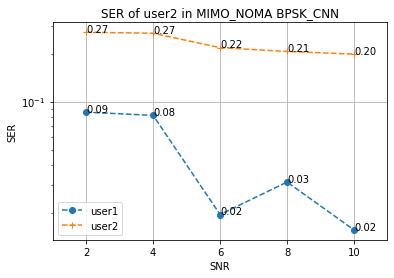

SNR : [ 2  4  6  8 10]
bit error for user 1 at testing : [0.0859375  0.08203125 0.01953125 0.03125    0.015625  ]
bit error for user 2 at testing : [0.2734375  0.26953125 0.21875    0.20703125 0.19921875]


In [ ]:
error1 = np.mean(ERROR_user1, axis=1)
error2 = np.mean((ERROR_user2), axis=1)
# print(H1_real)
plt.figure()
plt.semilogy(SNR_db, error1, ls='--', marker='o', label='user1')
plt.semilogy(SNR_db, error2, ls='--', marker='+', label='user2')
for i in range(5):
  label1 = "{:.2f}".format(error1[i])
  label2 = "{:.2f}".format(error2[i])
  plt.annotate(label1,(SNR_db[i],ERROR_user1[i]))
  plt.annotate(label2,(SNR_db[i],ERROR_user2[i]))
plt.grid()
plt.legend()
plt.xlim(pow(10, 0), pow(11, 1))
plt.xlabel('SNR')
plt.ylabel('SER')
plt.title('SER of user2 in MIMO_NOMA BPSK_CNN')
plt.savefig('SER_MIMO_NOMA_CNN_BPSK')
plt.show()
print("SNR : {}".format(SNR_db))
print("bit error for user 1 at testing : {}".format(error1))
print("bit error for user 2 at testing : {}".format(error2))